In [1]:
# !pip install -q numpy==1.19.5

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn import metrics

In [3]:
# setting to see all columns 
pd.set_option('display.max_columns', None)

# Load data and set input/output paths

In [4]:
from os.path import exists
# config: depends whether you're on Google Colab or local


# Get URL from github csv by clicking on Download > Copy Link Address

load_from_google_drive = False

if load_from_google_drive:
      # On google colab
      # Mount GDrive and attach it to the colab for data I/O
    from google.colab import drive
    drive.mount('/content/drive')
    input_dir = '/content/drive/My Drive/datum/vfp/data/input/'
    output_dir = '/content/drive/My Drive/datum/vfp/data/output/'
    os.makedirs(output_dir, exist_ok=True)

else:
  # If using jupyter-lab or jupyter notebook, load locally:
  input_dir = './data/input/'
  output_dir = './data/output/'
  output_dir = './data/output/bias_mitigation/'
  os.makedirs(output_dir, exist_ok = True)

import datetime
ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')


In [5]:
df = pd.read_csv(input_dir + 'features/egemaps_trimmed_to_3500ms_reading.csv', index_col = 0)
df

,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,mfcc3_sma3_amean,mfcc3_sma3_stddevNorm,mfcc4_sma3_amean,mfcc4_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amean,shimmerLocaldB_sma3nz_stddevNorm,HNRdBACF_sma3nz_amean,HNRdBACF_sma3nz_stddevNorm,logRelF0-H1-H2_sma3nz_amean,logRelF0-H1-H2_sma3nz_stddevNorm,logRelF0-H1-A3_sma3nz_amean,logRelF0-H1-A3_sma3nz_stddevNorm,F1frequency_sma3nz_amean,F1frequency_sma3nz_stddevNorm,F1bandwidth_sma3nz_amean,F1bandwidth_sma3nz_stddevNorm,F1amplitudeLogRelF0_sma3nz_amean,F1amplitudeLogRelF0_sma3nz_stddevNorm,F2frequency_sma3nz_amean,F2frequency_sma3nz_stddevNorm,F2bandwidth_sma3nz_amean,F2bandwidth_sma3nz_stddevNorm,F2amplitudeLogRelF0_sma3nz_amean,F2amplitudeLogRelF0_sma3nz_stddevNorm,F3frequency_sma3nz_amean,F3frequency_sma3nz_stddevNorm,F3bandwidth_sma3nz_amean,F3bandwidth_sma3nz_stddevNorm,F3amplitudeLogRelF0_sma3nz_amean,F3amplitudeLogRelF0_sma3nz_stddevNorm,alphaRatioV_sma3nz_amean,alphaRatioV_sma3nz_stddevNorm,hammarbergIndexV_sma3nz_amean,hammarbergIndexV_sma3nz_stddevNorm,slopeV0-500_sma3nz_amean,slopeV0-500_sma3nz_stddevNorm,slopeV500-1500_sma3nz_amean,slopeV500-1500_sma3nz_stddevNorm,spectralFluxV_sma3nz_amean,spectralFluxV_sma3nz_stddevNorm,mfcc1V_sma3nz_amean,mfcc1V_sma3nz_stddevNorm,mfcc2V_sma3nz_amean,mfcc2V_sma3nz_stddevNorm,mfcc3V_sma3nz_amean,mfcc3V_sma3nz_stddevNorm,mfcc4V_sma3nz_amean,mfcc4V_sma3nz_stddevNorm,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,wav_file,sid,target
file,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
./data/output/audio_16khz_trimmed_to_3500ms/VFPNorm5_Speech_3.wav,0 days,0 days 00:00:03.500000,24.461336,0.037431,23.723312,24.355984,25.054586,1.331274,73.213080,73.594894,11.351318,5.101816,0.122485,0.620136,0.056275,0.096881,0.190506,0.134231,2.044915,1.241683,0.937599,0.879002,0.027326,0.741953,19.960155,0.734777,10.003858,1.141002,17.355030,0.864219,9.503584,1.124546,0.013956,1.001164,1.015553,1.115319,6.046314,0.297644,8.089498,0.591674,30.732416,0.301900,545.95514,0.375950,1345.9199,0.145390,-126.361855,-0.704699,1629.6312,0.162519,953.54584,0.224587,-130.992830,-0.635548,2723.4675,0.110391,982.13290,0.228021,-133.31079,-0.601726,-18.214966,-0.448385,28.067295,0.259442,0.002183,8.043483,-0.006487,-2.550853,0.037261,0.644279,33.158165,0.219218,13.125827,0.888659,20.194817,0.960660,11.546698,1.320701,-10.499897,19.720942,-0.014141,0.013253,0.020270,4.584527,2.332362,0.160000,0.132288,0.248750,0.282906,-42.756520,VFPNorm5_Speech_3.wav,VFPNorm5,0
./data/output/audio_16khz_trimmed_to_3500ms/VFP3_Speech_3.wav,0 days,0 days 00:00:03.500000,35.569410,0.086336,34.194880,35.356564,37.120490,2.925610,124.230280,78.482620,17.067774,13.136017,0.414029,0.669968,0.090697,0.407420,0.697056,0.606359,4.994759,1.964337,4.262497,2.438508,0.118233,0.934098,27.306260,0.502252,3.430019,4.351334,9.838347,1.556058,-9.168840,-2

In [6]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


0.9276522754189136
9.870032673534539 6.204692153813272e-21


target
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: equivalentSoundLevel_dBp, dtype: object

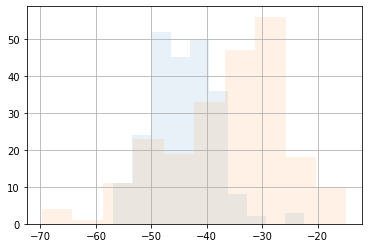

In [7]:
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

print(cohen_d(df_1['equivalentSoundLevel_dBp'].values, df_0['equivalentSoundLevel_dBp'].values))

from scipy.stats import ttest_ind

t,p = ttest_ind(df_1['equivalentSoundLevel_dBp'].values, df_0['equivalentSoundLevel_dBp'].values)
print(t,p)

df.groupby('target')['equivalentSoundLevel_dBp'].hist(alpha=0.1)


### Find distance correlation between intensity features and other features. 



In [21]:
import get_feature_names

egemaps_variables = get_feature_names.egemaps

In [9]:
import dcor
correlated_features_d = {}



intensity_features = ['loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope','loudnessPeaksPerSec','equivalentSoundLevel_dBp',
                      'HNRdBACF_sma3nz_amean','HNRdBACF_sma3nz_stddevNorm',]

other_features = list(set(egemaps_variables)-set(intensity_features)-set(['sid', 'target', 'filename']))


for x1 in intensity_features:
    for x2 in other_features:
        # if x2 in correlated_features.keys():
        #     continue #skip
        # else:
            dcor_result = float(dcor.distance_correlation(df[x1], df[x2]))
            if x2 not in correlated_features_d.keys():
                correlated_features_d[x2] = dcor_result
            elif x2 in correlated_features_d.keys():
                if dcor_result>correlated_features_d.get(x2):
                    # save the highest correlation between intensity features and nonintensity ones
                    correlated_features_d[x2] = dcor_result
                else:
                    # save the prior correlation
                    continue
            
            
    


In [10]:
correlated_features = pd.DataFrame(correlated_features_d, index = ['dcor']).T.reset_index().sort_values('dcor')[::-1]
correlated_features.columns = ['other_features', 'dcor']
correlated_features


,other_features,dcor
65,spectralFluxV_sma3nz_amean,0.896220
42,spectralFlux_sma3_amean,0.893693
52,F0semitoneFrom27.5Hz_sma3nz_amean,0.880880
2,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.879852
5,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.861650
...,...,...
6,mfcc3_sma3_stddevNorm,0.177411
36,mfcc3V_sma3nz_stddevNorm,0.150182
35,mfcc4V_sma3nz_stddevNorm,0.138563
11,slopeV0-500_sma3nz_stddevNorm,0.110363


In [11]:
print(correlated_features[correlated_features['dcor']>0.3].shape)
print(correlated_features[correlated_features['dcor']>0.4].shape)


(44, 2)
(20, 2)


In [12]:
print('remaining vars', 88-44)
print('remaining vars', 88-20)

remaining vars 44
remaining vars 68


In [25]:
correlated_with_intensity = correlated_features[correlated_features['dcor']>0.4].round(2)
correlated_with_intensity = correlated_with_intensity.reset_index(drop = True)
correlated_above_04 = correlated_with_intensity['other_features'].tolist()
uncorrelated_above_04 = set(egemaps_variables) - set(correlated_above_04)

correlated_with_intensity.to_csv(output_dir+'uncorrelated_dcor-040_intensity.csv')
correlated_with_intensity

,other_features,dcor
0,spectralFluxV_sma3nz_amean,0.90
1,spectralFlux_sma3_amean,0.89
2,F0semitoneFrom27.5Hz_sma3nz_amean,0.88
3,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.88
4,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.86
5,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.82
6,spectralFluxUV_sma3nz_amean,0.78
7,slopeUV500-1500_sma3nz_amean,0.70
8,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,0.57
9,slopeV500-1500_sma3nz_amean,0.57


In [26]:
correlated_with_intensity = correlated_features[correlated_features['dcor']>0.3].round(2)
correlated_with_intensity = correlated_with_intensity.reset_index(drop = True)
correlated_above_03 = correlated_with_intensity['other_features'].tolist()
uncorrelated_above_03 = set(egemaps_variables) - set(correlated_above_03)

correlated_with_intensity.to_csv(output_dir+'uncorrelated_dcor-030_intensity.csv')
correlated_with_intensity

,other_features,dcor
0,spectralFluxV_sma3nz_amean,0.90
1,spectralFlux_sma3_amean,0.89
2,F0semitoneFrom27.5Hz_sma3nz_amean,0.88
3,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.88
4,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.86
5,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.82
6,spectralFluxUV_sma3nz_amean,0.78
7,slopeUV500-1500_sma3nz_amean,0.70
8,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,0.57
9,slopeV500-1500_sma3nz_amean,0.57


In [27]:
%%time


models = [
    LogisticRegressionCV(solver='liblinear', penalty = 'l1', max_iter = 100),
    MLPClassifier(alpha = 1, max_iter= 1000),
    RandomForestClassifier(n_estimators= 100),
    SGDClassifier(loss='log', penalty="elasticnet", early_stopping=True, max_iter = 5000),
]


names = ['LogisticRegressionCV', "MLPClassifier","RandomForestClassifier",'SGDClassifier']

toy = False


for threshold in [0.3, 0.4]:

  for null_model in [True, False]:
      print('\npermute', null_model)
      # Create DFs for each independent variable

      if threshold == 0.3:
        variables = uncorrelated_above_03.copy()
        filename = 'uncorrelated_dcor-030_intensity'
      elif threshold == 0.4:
        variables = uncorrelated_above_04.copy()
        filename = 'uncorrelated_dcor-040_intensity'

          

      X = df[variables].values
      print(X.shape)
      y = df['target'].values
      groups = df['sid'].values



      if toy:
        n_bootstraps = 3
      else:
        n_bootstraps = 50

      if null_model:
          y = np.random.permutation(y) #CHECK


      y_pred_all = {}
      roc_auc_all = {}
      for model, name in zip(models, names):
        y_pred_all[name] = []
        roc_auc_all[name] = []
        pipe = Pipeline(steps=[
                ('scaler', StandardScaler()), 
                ('model', model)])

        ## Performing bootstrapping
        splitter = GroupShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
        for i, (train_index, test_index) in enumerate(splitter.split(X, y, groups)):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            pipe.fit(X_train,y_train)     

            # # Evaluate
                     
            y_pred = pipe.predict(X_test) 
            roc_auc = metrics.roc_auc_score(y_test, y_pred)  # ROC AUC takes probabilities but here we match what pydra-ml does: https://github.com/nipype/pydra-ml/issues/56

            y_pred_all[name].append(y_pred)
            roc_auc_all[name].append(roc_auc)

      results_i = []
      for name in ['LogisticRegressionCV','MLPClassifier','RandomForestClassifier','SGDClassifier']:
        scores = roc_auc_all.get(name)
        roc_auc_median = np.round(np.median(scores),2)
        roc_auc_5 = np.round(np.percentile(scores, 5),2)
        roc_auc_95 = np.round(np.percentile(scores, 95),2)
        results_str = f'{roc_auc_median} ({roc_auc_5}–{roc_auc_95}; )'
        results_str = results_str.replace('0.', '.')
        results_i.append([name, results_str])

        if null_model:
          print(name, str(roc_auc_median).replace('0.', '.'))
      if not null_model:
          results_i_df = pd.DataFrame(results_i, ).T
          display(results_i_df)
          results_i_df.to_csv(output_dir+f'results_{filename}_permute-{null_model}_duration_{ts}.csv')




      # pd.DataFrame(y_pred_all)



permute True
(453, 44)
LogisticRegressionCV .5
MLPClassifier .49
RandomForestClassifier .53
SGDClassifier .51

permute False
(453, 44)


,0,1,2,3
0,LogisticRegressionCV,MLPClassifier,RandomForestClassifier,SGDClassifier
1,.84 (.78–.89; ),.83 (.76–.9; ),.85 (.78–.91; ),.79 (.66–.87; )



permute True
(453, 68)


/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/

LogisticRegressionCV .5
MLPClassifier .47
RandomForestClassifier .45
SGDClassifier .48

permute False
(453, 68)


/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/sklearn/svm/

,0,1,2,3
0,LogisticRegressionCV,MLPClassifier,RandomForestClassifier,SGDClassifier
1,.88 (.8–.92; ),.87 (.81–.92; ),.87 (.78–.93; ),.83 (.76–.9; )


CPU times: user 27min 28s, sys: 7min 43s, total: 35min 12s
Wall time: 25min 8s
